<a href="https://colab.research.google.com/github/TakshDhabalia/Research-and-MusicGeneration/blob/CNN_audio_Cat/Improved_Audio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install numpy matplotlib tensorflow scikit-learn


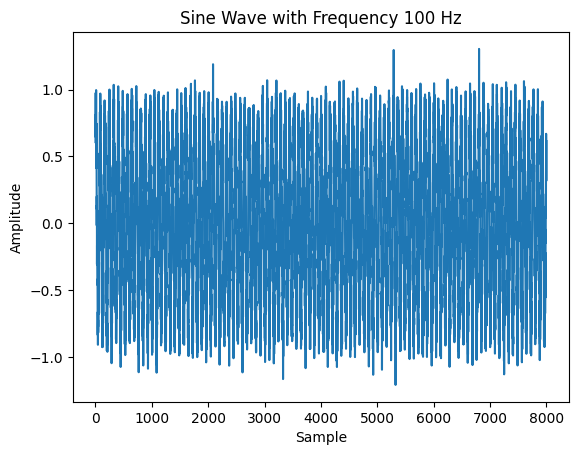

In [3]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split, KFold

# Function to generate sinusoidal waves with noise
def generate_sine_wave_with_noise(freq, sample_rate, duration, amplitude=1.0, phase=0.0, noise_level=0.1):
    x = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    frequencies = x * freq
    y = amplitude * np.sin((2 * np.pi) * frequencies + phase)
    noise = np.random.normal(0, noise_level, y.shape)
    return x, y + noise

# Parameters
sample_rate = 8000  # 8 kHz sample rate
duration = 1.0  # 1 second
frequencies = [100, 200, 300, 400, 500]  # Frequencies in Hz
num_examples_per_freq = 50  # Number of examples per frequency

# Generate dataset with noise
dataset = []
labels = []
for freq in frequencies:
    for _ in range(num_examples_per_freq):
        amplitude = np.random.uniform(0.5, 1.5)  # Random amplitude
        phase = np.random.uniform(0, 2*np.pi)  # Random phase
        _, wave = generate_sine_wave_with_noise(freq, sample_rate, duration, amplitude, phase, noise_level=0.1)
        dataset.append(wave)
        labels.append(freq)

# Convert to numpy arrays
dataset = np.array(dataset)
labels = np.array(labels)

# Normalize the dataset
dataset = (dataset - np.mean(dataset)) / np.std(dataset)

# Create a mapping from frequencies to integer labels
label_map = {freq: i for i, freq in enumerate(frequencies)}
integer_labels = np.array([label_map[freq] for freq in labels])

# Plot an example
plt.plot(dataset[0])
plt.title(f"Sine Wave with Frequency {labels[0]} Hz")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

# Reshape dataset for the CNN to have 1024 input channels
num_input_channels = 1024
dataset = dataset[:, :num_input_channels].reshape(-1, num_input_channels, 1)


In [4]:
# Parameters for k-fold cross-validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Cross-validation loop
fold = 1
accuracies = []

for train_index, test_index in kf.split(dataset):
    X_train, X_test = dataset[train_index], dataset[test_index]
    y_train, y_test = integer_labels[train_index], integer_labels[test_index]

    # Define the model
    model = Sequential([
        Conv1D(512, 8, activation='relu', input_shape=(num_input_channels, 1)),
        MaxPooling1D(4),
        Dropout(0.25),
        Conv1D(512, 8, activation='relu'),
        MaxPooling1D(4),
        Dropout(0.25),
        Conv1D(512, 8, activation='relu'),
        Flatten(),
        Dense(360, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)
    print(f"Fold {fold}, Test Accuracy: {accuracy * 100:.2f}%")
    fold += 1

# Calculate average accuracy
average_accuracy = np.mean(accuracies)
print(f"Average Test Accuracy: {average_accuracy * 100:.2f}%")


Fold 1, Test Accuracy: 100.00%
Fold 2, Test Accuracy: 100.00%
Fold 3, Test Accuracy: 100.00%
Fold 4, Test Accuracy: 100.00%


Fold 5, Test Accuracy: 100.00%
Average Test Accuracy: 100.00%


1/1 [==============================] - 0s 353ms/step


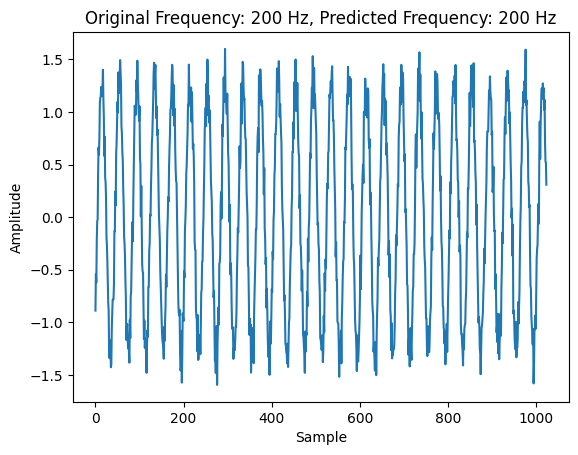

In [5]:
import random

# Get a random sample from the test set
index = random.randint(0, len(X_test) - 1)
sample = X_test[index]

# Predict the label
prediction = model.predict(sample.reshape(1, num_input_channels, 1))
predicted_label = np.argmax(prediction)

# Original label
original_label = y_test[index]

# Map integer label back to frequency
original_frequency = frequencies[original_label]
predicted_frequency = frequencies[predicted_label]

# Plot the waveform
plt.plot(sample)
plt.title(f"Original Frequency: {original_frequency} Hz, Predicted Frequency: {predicted_frequency} Hz")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()


In [6]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 1017, 512)         4608      
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 254, 512)          0         
 g1D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 254, 512)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, 247, 512)          2097664   
                                                                 
 max_pooling1d_9 (MaxPoolin  (None, 61, 512)           0         
 g1D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 61, 512)          

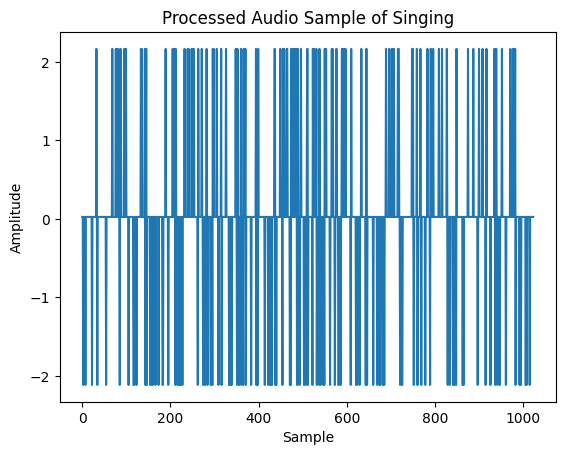

In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Function to load and process .wav file
def process_wav_file(file_path, num_samples=1024):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)
    # Ensure the audio is at least num_samples long
    if len(y) < num_samples:
        y = np.pad(y, (0, max(0, num_samples - len(y))), 'constant')
    # Take the first num_samples
    y = y[:num_samples]
    # Normalize the audio
    y = (y - np.mean(y)) / np.std(y)
    return y.reshape(-1, 1)

# Load and process the .wav file of your singing
file_path = '/content/VK_Sa_181221.wav'  # Replace with the path to your .wav file
input_data = process_wav_file(file_path)

# Plot the processed audio sample
plt.plot(input_data)
plt.title("Processed Audio Sample of Singing")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()


In [13]:
# Ensure the input_data is the correct shape
input_data = input_data.reshape(1, 1024, 1)

# Predict the frequency
prediction = model.predict(input_data)
predicted_label = np.argmax(prediction)
confidence = prediction[0][predicted_label]

# Map the predicted label back to the frequency
predicted_frequency = frequencies[predicted_label]

print(f"Predicted Frequency: {predicted_frequency} Hz")
print(f"Confidence: {confidence * 100:.2f}%")


1/1 [==============================] - 0s 19ms/step
Predicted Frequency: 100 Hz
Confidence: 92.39%


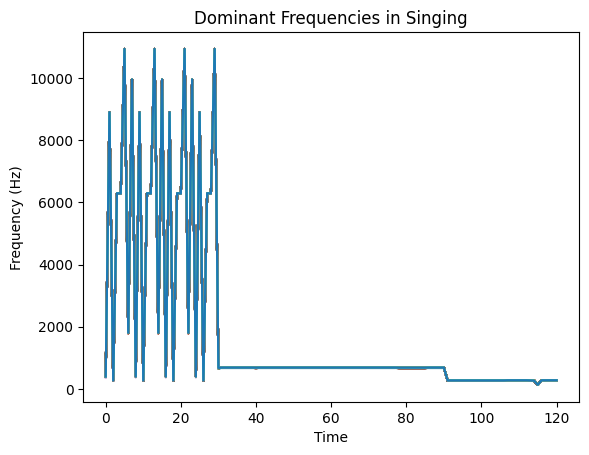

Actual Dominant Frequency: 686.64 Hz
Accuracy: 14.56%


In [16]:
# Calculate the dominant frequency of the singing using librosa
def get_dominant_frequency(y, sr):
    D = np.abs(librosa.stft(y))**2
    frequencies, times, S = librosa.reassigned_spectrogram(y, sr=sr, fill_nan=True)
    idx = np.argmax(S, axis=0)
    dominant_frequencies = frequencies[idx]
    return dominant_frequencies

# Load the singing file again to get the full signal
y, sr = librosa.load(file_path, sr=None)
dominant_frequencies = get_dominant_frequency(y, sr)

# Plot the dominant frequencies
plt.plot(dominant_frequencies)
plt.title("Dominant Frequencies in Singing")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

# Use the median dominant frequency as the actual frequency for comparison
actual_frequency = np.median(dominant_frequencies)
print(f"Actual Dominant Frequency: {actual_frequency:.2f} Hz")

# Calculate and display the accuracy
accuracy = 1 - abs(predicted_frequency - actual_frequency) / actual_frequency
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
!pip install numpy matplotlib tensorflow scikit-learn librosa

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import librosa

# Generate Dataset with 1024 Input Channels
def generate_sine_wave_with_noise(freq, sample_rate, duration, amplitude=1.0, phase=0.0, noise_level=0.1):
    x = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    frequencies = x * freq
    y = amplitude * np.sin((2 * np.pi) * frequencies + phase)
    noise = np.random.normal(0, noise_level, y.shape)
    return x, y + noise

sample_rate = 8000  # 8 kHz sample rate
duration = 1.0  # 1 second
frequencies = [100, 200, 300, 400, 500]  # Frequencies in Hz
num_examples_per_freq = 50  # Number of examples per frequency

dataset = []
labels = []
for freq in frequencies:
    for _ in range(num_examples_per_freq):
        amplitude = np.random.uniform(0.5, 1.5)  # Random amplitude
        phase = np.random.uniform(0, 2*np.pi)  # Random phase
        _, wave = generate_sine_wave_with_noise(freq, sample_rate, duration, amplitude, phase, noise_level=0.1)
        dataset.append(wave)
        labels.append(freq)

dataset = np.array(dataset)
labels = np.array(labels)

dataset = (dataset - np.mean(dataset)) / np.std(dataset)

label_map = {freq: i for i, freq in enumerate(frequencies)}
integer_labels = np.array([label_map[freq] for freq in labels])

num_input_channels = 1024
dataset = dataset[:, :num_input_channels].reshape(-1, num_input_channels, 1)

# Define and Train the Model with K-fold Cross-Validation
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

fold = 1
accuracies = []

for train_index, test_index in kf.split(dataset):
    X_train, X_test = dataset[train_index], dataset[test_index]
    y_train, y_test = integer_labels[train_index], integer_labels[test_index]

    model = Sequential([
        Conv1D(512, 8, activation='relu', input_shape=(1024, 1)),
        MaxPooling1D(4),
        Dropout(0.25),
        Conv1D(512, 8, activation='relu'),
        MaxPooling1D(4),
        Dropout(0.25),
        Conv1D(512, 8, activation='relu'),
        Flatten(),
        Dense(360, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=50, verbose=0)

    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    accuracies.append(accuracy)
    print(f"Fold {fold}, Test Accuracy: {accuracy * 100:.2f}%")
    fold += 1

average_accuracy = np.mean(accuracies)
print(f"Average Test Accuracy: {average_accuracy * 100:.2f}%")

# Process .wav File
def process_wav_file(file_path, num_samples=1024):
    y, sr = librosa.load(file_path, sr=None)
    if len(y) < num_samples:
        y = np.pad(y, (0, max(0, num_samples - len(y))), 'constant')
    y = y[:num_samples]
    y = (y - np.mean(y)) / np.std(y)
    return y.reshape(-1, 1)

file_path = 'path_to_your_singing_file.wav'  # Replace with the path to your .wav file
input_data = process_wav_file(file_path)
input_data = input_data.reshape(1, 1024, 1)

# Predict Frequency
prediction = model.predict(input_data)
predicted_label = np.argmax(prediction)
confidence = prediction[0][predicted_label]
predicted_frequency = frequencies[predicted_label]

print(f"Predicted Frequency: {predicted_frequency} Hz")
print(f"Confidence: {confidence * 100:.2f}%")

# Calculate the dominant frequency of the singing using librosa
def get_dominant_frequency(y, sr):
    D = np.abs(librosa.stft(y))**2
    frequencies, times, S = librosa.reassigned_spectrogram(y, sr=sr, fill_nan=True)
    idx = np.argmax(S, axis=0)
    dominant_frequencies = frequencies[idx]
    return dominant_frequencies

# Load the singing file again to get the full signal
y, sr = librosa.load(file_path, sr=None)
dominant_frequencies = get_dominant_frequency(y, sr)

# Plot the dominant frequencies
plt.plot(dominant_frequencies)
plt.title("Dominant Frequencies in Singing")
plt.xlabel("Time")
plt.ylabel("Frequency (Hz)")
plt.show()

# Use the median dominant frequency as the actual frequency for comparison
actual_frequency = np.median(dominant_frequencies)
print(f"Actual Dominant Frequency: {actual_frequency:.2f} Hz")

# Calculate and display the accuracy
accuracy = 1 - abs(predicted_frequency - actual_frequency) / actual_frequency
print(f"Accuracy: {accuracy * 100:.2f}%")

# Plot Confidence
plt.figure(figsize=(10, 5))
plt.bar(range(len(prediction[0])), prediction[0])
plt.xlabel('Class Label')
plt.ylabel('Confidence')
plt.title('Model Confidence for Each Class')
plt.show()
